<a href="https://colab.research.google.com/github/shinyumi43/deep-learning/blob/main/cifar10_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import os
import matplotlib.pyplot as plt

# 배치 정규화를 사용하여 학습 속도 및 정확도 향상에 기여 가능
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, with_BN, stride=1):
        super(BasicBlock, self).__init__()
        self.with_BN = with_BN

        # 3x3 필터를 사용 (너비와 높이를 줄일 때는 stride 값 조절)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        if with_BN: # 배치 정규화(batch normalization)를 사용하는 경우
            self.bn1 = nn.BatchNorm2d(planes) 

        # 3x3 필터를 사용 (패딩을 1만큼 주기 때문에 너비와 높이가 동일)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        if with_BN: # 배치 정규화(batch normalization)를 사용하는 경우
            self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential() # 단순한 identity mapping인 경우
        if stride != 1: # stride가 1이 아니라면, Identity mapping이 아닌 경우
            modules = [nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False)]
            if with_BN:
                modules.append(nn.BatchNorm2d(planes))
            self.shortcut = nn.Sequential(*modules)

    def forward(self, x):
        if self.with_BN: # 배치 정규화(batch normalization)를 사용하는 경우
            out = F.relu(self.bn1(self.conv1(x)))
            out = self.bn2(self.conv2(out))
        else:
            out = F.relu(self.conv1(x))
            out = self.conv2(out)
        out += self.shortcut(x) # (핵심) skip connection
        out = F.relu(out)
        return out


# ResNet 클래스 정의
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, with_BN, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.with_BN = with_BN

        # 64개의 3x3 필터(filter)를 사용
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        if with_BN: # 배치 정규화(batch normalization)를 사용하는 경우
            self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, with_BN, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, with_BN, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, with_BN, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, with_BN, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, with_BN, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, with_BN, stride))
            self.in_planes = planes # 다음 레이어를 위해 채널 수 변경
        return nn.Sequential(*layers)

    def forward(self, x):
        if self.with_BN: # 배치 정규화(batch normalization)를 사용하는 경우
            out = F.relu(self.bn1(self.conv1(x)))
        else:
            out = F.relu(self.conv1(x))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


# ResNet18 함수 정의
def ResNet18(with_BN):
    return ResNet(BasicBlock, [2, 2, 2, 2], with_BN)

In [ ]:
import torchvision
import torchvision.transforms as transforms

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=4)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
criterion = nn.CrossEntropyLoss() # 분류(classification) 문제


def train(net, optimizer, epoch, step):
    net.train()
    correct = 0 # 정답을 맞힌 이미지 개수
    total = 0 # 전체 이미지 개수
    steps = [] # 학습 스텝(step)
    losses = [] # 각 스텝에서의 손실(loss)

    for _, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.cuda(), targets.cuda()

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()
        total += targets.size(0)

        steps.append(step)
        losses.append(loss.item())
        step += 1

    return correct / total, steps, losses


def test(net, optimizer, epoch):
    net.eval()
    correct = 0 # 정답을 맞힌 이미지 개수
    total = 0 # 전체 이미지 개수
    loss = 0 # 손실(loss)

    for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.cuda(), targets.cuda()

        outputs = net(inputs)
        loss += criterion(outputs, targets).item()

        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()
        total += targets.size(0)

    return correct / total, loss

In [ ]:
# 배치 정규화를 적용하지 않은 모델의 성능 평가
print('모델 파라미터를 초기화합니다.')
net = ResNet18(with_BN=False).cuda()
learning_rate = 0.01
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)

total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print('학습 가능한 총 파라미터 수:', total_params)

모델 파라미터를 초기화합니다.
학습 가능한 총 파라미터 수: 11164362


In [ ]:
# 배치 정규화를 적용하지 않은 모델의 학습 진행
without_BN_train_accuracies = []
without_BN_steps = []
without_BN_train_losses = []
without_BN_test_accuracies = []
without_BN_test_losses = []

epochs = 20

for epoch in range(0, epochs):
    print(f'[ Epoch: {epoch}/{epochs} ]')
    train_accuracy, steps, train_losses = train(net, optimizer, epoch, len(without_BN_steps))
    without_BN_train_accuracies.append(train_accuracy)
    without_BN_steps.extend(steps)
    without_BN_train_losses.extend(train_losses)
    print(f'Train accuracy = {train_accuracy * 100:.2f} / Train loss = {sum(train_losses)}')

    test_accuracy, test_loss = test(net, optimizer, epoch)
    without_BN_test_accuracies.append(test_accuracy)
    without_BN_test_losses.append(test_loss)
    print(f'Test accuracy = {test_accuracy * 100:.2f} / Test loss = {test_loss}')

[ Epoch: 0/20 ]


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train accuracy = 14.51 / Train loss = 869.6676378250122
Test accuracy = 22.84 / Test loss = 209.2683161497116
[ Epoch: 1/20 ]
Train accuracy = 26.38 / Train loss = 776.2349678277969
Test accuracy = 33.11 / Test loss = 181.89975690841675
[ Epoch: 2/20 ]
Train accuracy = 33.49 / Train loss = 706.3441342115402
Test accuracy = 42.02 / Test loss = 161.3595894575119
[ Epoch: 3/20 ]
Train accuracy = 39.43 / Train loss = 649.3191469907761
Test accuracy = 42.29 / Test loss = 172.2374382019043
[ Epoch: 4/20 ]
Train accuracy = 43.60 / Train loss = 604.7677371501923
Test accuracy = 45.52 / Test loss = 152.38730776309967
[ Epoch: 5/20 ]
Train accuracy = 47.16 / Train loss = 571.6314988136292
Test accuracy = 47.43 / Test loss = 144.02159798145294
[ Epoch: 6/20 ]
Train accuracy = 50.32 / Train loss = 543.085955619812
Test accuracy = 51.43 / Test loss = 135.34159314632416
[ Epoch: 7/20 ]
Train accuracy = 53.20 / Train loss = 511.34741723537445
Test accuracy = 54.46 / Test loss = 128.14318549633026
[ E

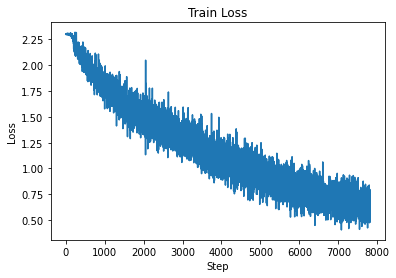

In [ ]:
# 학습 과정에서의 스텝(step)에 따른 손실(loss) 값을 시각화
plt.plot(without_BN_steps, without_BN_train_losses)
plt.title('Train Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()

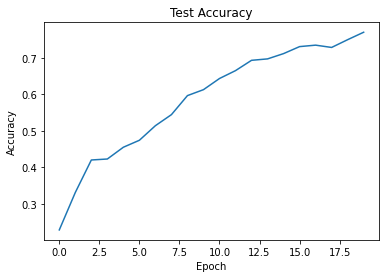

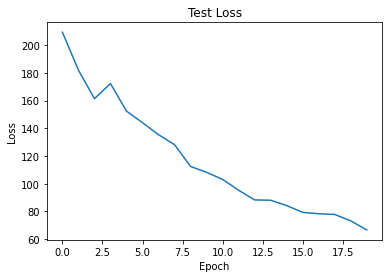

In [ ]:
# 테스트 정확도(accuracy) 및 손실(loss) 값을 시각화
plt.plot([i for i in range(len(without_BN_test_accuracies))], without_BN_test_accuracies)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

plt.plot([i for i in range(len(without_BN_test_losses))], without_BN_test_losses)
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
# 배치 정규화를 적용한 모델의 성능 평가
print('모델 파라미터를 초기화합니다.')
net = ResNet18(with_BN=True).cuda()
learning_rate = 0.01
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)

total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print('학습 가능한 총 파라미터 수:', total_params)

모델 파라미터를 초기화합니다.
학습 가능한 총 파라미터 수: 11173962


In [ ]:
# 배치 정규화를 적용한 모델의 학습 진행
with_BN_train_accuracies = []
with_BN_steps = []
with_BN_train_losses = []
with_BN_test_accuracies = []
with_BN_test_losses = []

epochs = 20

for epoch in range(0, epochs):
    print(f'[ Epoch: {epoch}/{epochs} ]')
    train_accuracy, steps, train_losses = train(net, optimizer, epoch, len(with_BN_steps))
    with_BN_train_accuracies.append(train_accuracy)
    with_BN_steps.extend(steps)
    with_BN_train_losses.extend(train_losses)
    print(f'Train accuracy = {train_accuracy * 100:.2f} / Train loss = {sum(train_losses)}')

    test_accuracy, test_loss = test(net, optimizer, epoch)
    with_BN_test_accuracies.append(test_accuracy)
    with_BN_test_losses.append(test_loss)
    print(f'Test accuracy = {test_accuracy * 100:.2f} / Test loss = {test_loss}')

[ Epoch: 0/20 ]


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train accuracy = 46.85 / Train loss = 570.6548797488213
Test accuracy = 39.03 / Test loss = 200.8996330499649
[ Epoch: 1/20 ]
Train accuracy = 67.09 / Train loss = 362.0836772322655
Test accuracy = 70.95 / Test loss = 85.07034677267075
[ Epoch: 2/20 ]
Train accuracy = 74.62 / Train loss = 281.6587628722191
Test accuracy = 75.63 / Test loss = 73.47361281514168
[ Epoch: 3/20 ]
Train accuracy = 78.87 / Train loss = 236.18779051303864
Test accuracy = 70.59 / Test loss = 96.60477298498154
[ Epoch: 4/20 ]
Train accuracy = 81.82 / Train loss = 205.5984617471695
Test accuracy = 80.46 / Test loss = 57.32708975672722
[ Epoch: 5/20 ]
Train accuracy = 83.88 / Train loss = 184.50615027546883
Test accuracy = 82.41 / Test loss = 52.98707504570484
[ Epoch: 6/20 ]
Train accuracy = 85.29 / Train loss = 166.26244361698627
Test accuracy = 81.53 / Test loss = 56.29847227036953
[ Epoch: 7/20 ]
Train accuracy = 86.49 / Train loss = 152.2293811738491
Test accuracy = 84.16 / Test loss = 47.713344275951385
[ Ep

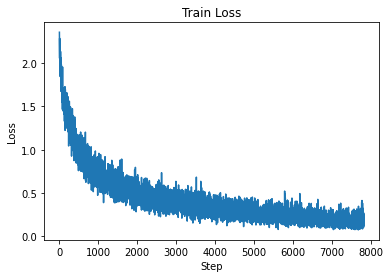

In [ ]:
# 학습 과정에서의 스텝(step)에 따른 손실(loss) 값을 시각화
plt.plot(with_BN_steps, with_BN_train_losses)
plt.title('Train Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()

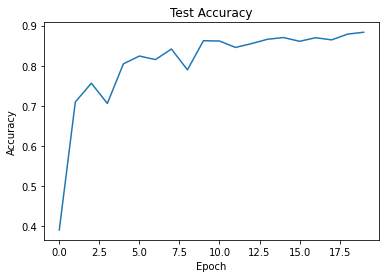

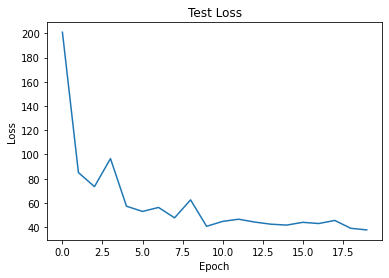

In [ ]:
# 테스트 정확도(accuracy) 및 손실(loss) 값을 시각화
plt.plot([i for i in range(len(with_BN_test_accuracies))], with_BN_test_accuracies)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

plt.plot([i for i in range(len(with_BN_test_losses))], with_BN_test_losses)
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

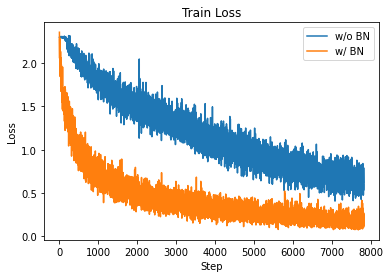

In [ ]:
# 배치 정규화를 적용하지 않은 모델과 배치 정규화를 적용한 모델 간의 비교
plt.plot(without_BN_steps, without_BN_train_losses)
plt.plot(with_BN_steps, with_BN_train_losses)
plt.title('Train Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend(['w/o BN', 'w/ BN'])
plt.show()

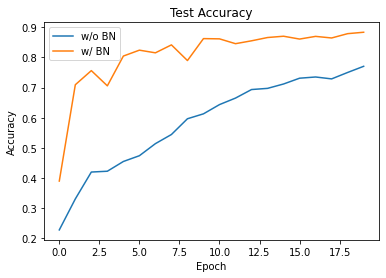

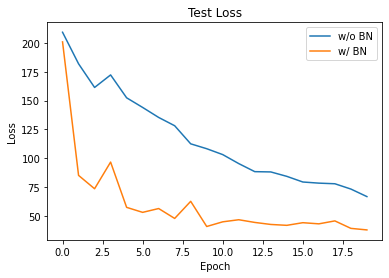

In [ ]:
plt.plot([i for i in range(len(without_BN_test_accuracies))], without_BN_test_accuracies)
plt.plot([i for i in range(len(with_BN_test_accuracies))], with_BN_test_accuracies)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['w/o BN', 'w/ BN'])
plt.show()

plt.plot([i for i in range(len(without_BN_test_losses))], without_BN_test_losses)
plt.plot([i for i in range(len(with_BN_test_losses))], with_BN_test_losses)
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['w/o BN', 'w/ BN'])
plt.show()